In [3]:
import pandas as pd
import numpy as np

# Plots
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.offline as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.tools as tls
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)
import squarify

# Data processing, metrics and modeling
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score, confusion_matrix,  roc_curve, precision_recall_curve, accuracy_score, roc_auc_score
import lightgbm as lgbm


# Stats
import scipy.stats as ss
from scipy import interp
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

# Time
from contextlib import contextmanager
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

#ignore warning messages 
import warnings
warnings.filterwarnings('ignore') 

In [4]:
data = pd.read_csv('../data/diabetes.csv')

In [5]:
display(data.info(),data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


None

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [6]:
# 2 datasets
D = data[(data['Outcome'] != 0)]
H = data[(data['Outcome'] == 0)]

#------------COUNT-----------------------
def target_count():
    trace = go.Bar( x = data['Outcome'].value_counts().values.tolist(), 
                    y = ['healthy','diabetic' ], 
                    orientation = 'h', 
                    text=data['Outcome'].value_counts().values.tolist(), 
                    textfont=dict(size=15),
                    textposition = 'auto',
                    opacity = 0.8,marker=dict(
                    color=['lightskyblue', 'gold'],
                    line=dict(color='#000000',width=1.5)))

    layout = dict(title =  'Count of Outcome variable')

    fig = dict(data = [trace], layout=layout)
    py.iplot(fig)

#------------PERCENTAGE-------------------
def target_percent():
    trace = go.Pie(labels = ['healthy','diabetic'], values = data['Outcome'].value_counts(), 
                   textfont=dict(size=15), opacity = 0.8,
                   marker=dict(colors=['lightskyblue', 'gold'], 
                               line=dict(color='#000000', width=1.5)))


    layout = dict(title =  'Distribution of Outcome variable')

    fig = dict(data = [trace], layout=layout)
    py.iplot(fig)

In [7]:
target_count()
target_percent()

In [8]:
data[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = data[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN)

In [9]:
# Define missing plot to detect all missing values in dataset
def missing_plot(dataset, key) :
    null_feat = pd.DataFrame(len(dataset[key]) - dataset.isnull().sum(), columns = ['Count'])
    percentage_null = pd.DataFrame((len(dataset[key]) - (len(dataset[key]) - dataset.isnull().sum()))/len(dataset[key])*100, columns = ['Count'])
    percentage_null = percentage_null.round(2)

    trace = go.Bar(x = null_feat.index, y = null_feat['Count'] ,opacity = 0.8, text = percentage_null['Count'],  textposition = 'auto',marker=dict(color = '#7EC0EE',
            line=dict(color='#000000',width=1.5)))

    layout = dict(title =  "Missing Values (count & %)")

    fig = dict(data = [trace], layout=layout)
    py.iplot(fig)

In [10]:
# Plotting 
missing_plot(data, 'Outcome')

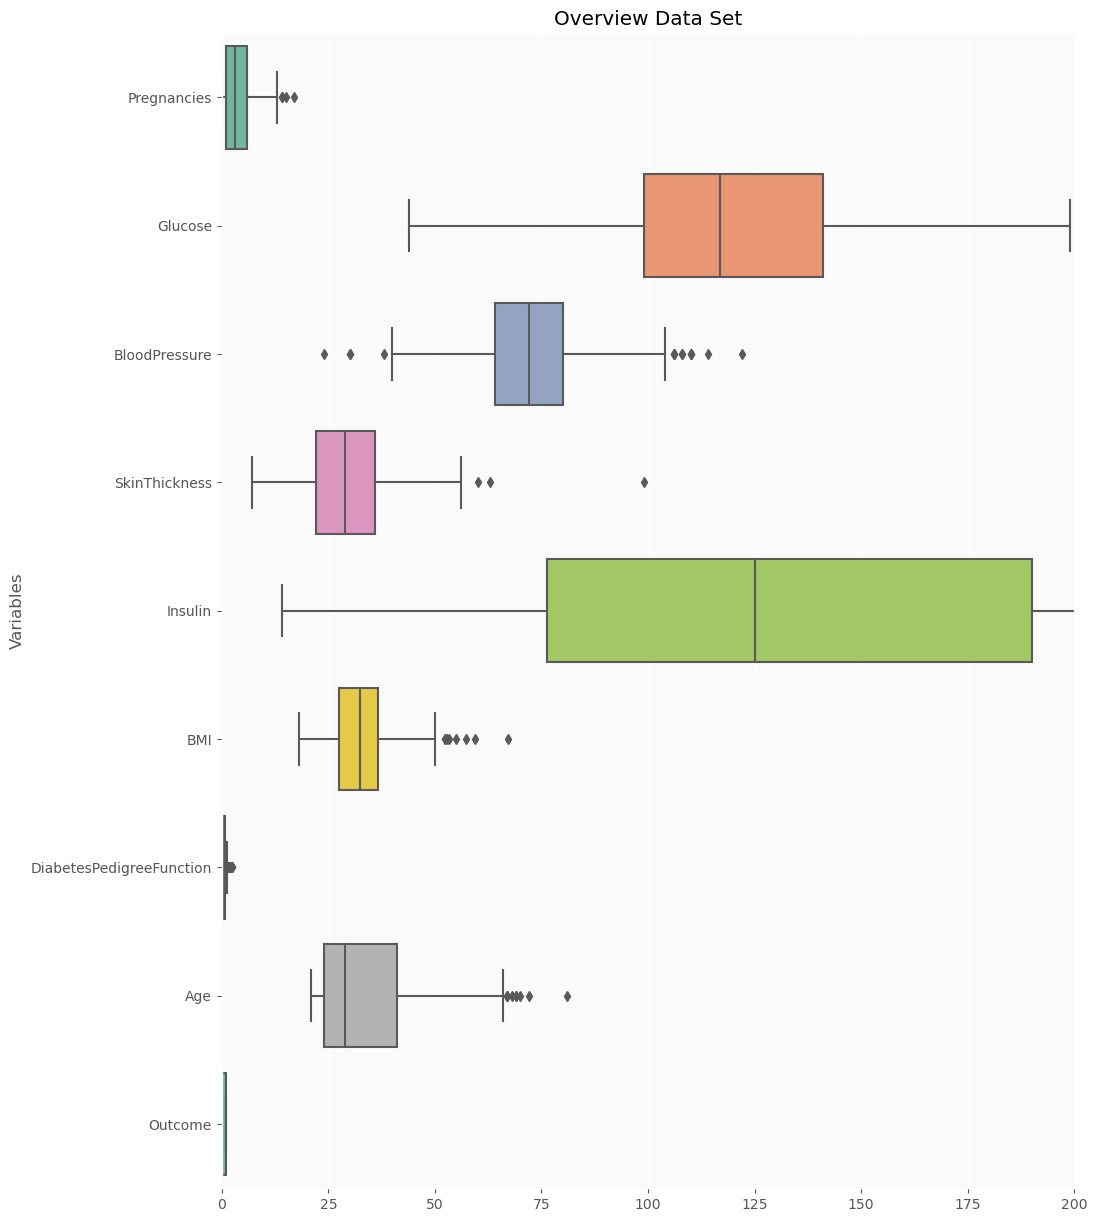

In [11]:
plt.style.use('ggplot') # Using ggplot2 style visuals 

f, ax = plt.subplots(figsize=(11, 15))

ax.set_facecolor('#fafafa')
ax.set(xlim=(-.05, 200))
plt.ylabel('Variables')
plt.title("Overview Data Set")
ax = sns.boxplot(data = data, 
  orient = 'h', 
  palette = 'Set2')

In [12]:
def correlation_plot():
    #correlation
    correlation = data.corr()
    #tick labels
    matrix_cols = correlation.columns.tolist()
    #convert to array
    corr_array  = np.array(correlation)
    trace = go.Heatmap(z = corr_array,
                       x = matrix_cols,
                       y = matrix_cols,
                       colorscale='Viridis',
                       colorbar   = dict() ,
                      )
    layout = go.Layout(dict(title = 'Correlation Matrix for variables',
                            #autosize = False,
                            #height  = 1400,
                            #width   = 1600,
                            margin  = dict(r = 0 ,l = 100,
                                           t = 0,b = 100,
                                         ),
                            yaxis   = dict(tickfont = dict(size = 9)),
                            xaxis   = dict(tickfont = dict(size = 9)),
                           )
                      )
    fig = go.Figure(data = [trace],layout = layout)
    py.iplot(fig)

In [13]:
correlation_plot()

In [14]:
def median_target(var):   
    temp = data[data[var].notnull()]
    temp = temp[[var, 'Outcome']].groupby(['Outcome'])[[var]].median().reset_index()
    return temp

In [15]:
def plot_distribution(data_select, size_bin) :  
    # 2 datasets
    tmp1 = D[data_select]
    tmp2 = H[data_select]
    hist_data = [tmp1, tmp2]
    
    group_labels = ['diabetic', 'healthy']
    colors = ['#FFD700', '#7EC0EE']

    fig = ff.create_distplot(hist_data, group_labels, colors = colors, show_hist = True, bin_size = size_bin, curve_type='kde')
    
    fig['layout'].update(title = data_select)

    py.iplot(fig, filename = 'Density plot')

In [16]:
plot_distribution('Insulin', 0)

In [17]:
median_target('Insulin')

,Outcome,Insulin
0,0,102.5
1,1,169.5


In [18]:
data.loc[(data['Outcome'] == 0 ) & (data['Insulin'].isnull()), 'Insulin'] = 102.5
data.loc[(data['Outcome'] == 1 ) & (data['Insulin'].isnull()), 'Insulin'] = 169.5

In [19]:
plot_distribution('Glucose', 0)

In [20]:
median_target('Glucose')

,Outcome,Glucose
0,0,107.0
1,1,140.0


In [21]:
data.loc[(data['Outcome'] == 0 ) & (data['Glucose'].isnull()), 'Glucose'] = 107
data.loc[(data['Outcome'] == 1 ) & (data['Glucose'].isnull()), 'Glucose'] = 140

In [22]:
plot_distribution('SkinThickness', 10)

In [23]:
median_target('SkinThickness')

,Outcome,SkinThickness
0,0,27.0
1,1,32.0


In [24]:
data.loc[(data['Outcome'] == 0 ) & (data['SkinThickness'].isnull()), 'SkinThickness'] = 27
data.loc[(data['Outcome'] == 1 ) & (data['SkinThickness'].isnull()), 'SkinThickness'] = 32

In [25]:
plot_distribution('BloodPressure', 5)

In [26]:
median_target('BloodPressure')

,Outcome,BloodPressure
0,0,70.0
1,1,74.5


In [27]:
data.loc[(data['Outcome'] == 0 ) & (data['BloodPressure'].isnull()), 'BloodPressure'] = 70
data.loc[(data['Outcome'] == 1 ) & (data['BloodPressure'].isnull()), 'BloodPressure'] = 74.5

In [28]:
plot_distribution('BMI', 0)

In [29]:
median_target('BMI')

,Outcome,BMI
0,0,30.1
1,1,34.3


In [30]:
data.loc[(data['Outcome'] == 0 ) & (data['BMI'].isnull()), 'BMI'] = 30.1
data.loc[(data['Outcome'] == 1 ) & (data['BMI'].isnull()), 'BMI'] = 34.3

In [31]:
#plot distribution 
plot_distribution('Age', 0)
plot_distribution('Pregnancies', 0)
plot_distribution('DiabetesPedigreeFunction', 0)

In [32]:
missing_plot(data, 'Outcome')

In [36]:
target_col = ["Outcome"]
cat_cols   = data.nunique()[data.nunique() < 12].keys().tolist()
cat_cols   = [x for x in cat_cols ]
#numerical columns
num_cols   = [x for x in data.columns if x not in cat_cols + target_col]
#Binary columns with 2 values
bin_cols   = data.nunique()[data.nunique() == 2].keys().tolist()
#Columns more than 2 values
multi_cols = [i for i in cat_cols if i not in bin_cols]

#Label encoding Binary columns
le = LabelEncoder()
for i in bin_cols :
    data[i] = le.fit_transform(data[i])
    
#Duplicating columns for multi value columns
data = pd.get_dummies(data = data,columns = multi_cols )

#Scaling Numerical columns
std = StandardScaler()
scaled = std.fit_transform(data[num_cols])
scaled = pd.DataFrame(scaled,columns=num_cols)

#dropping original values merging scaled values for numerical columns
df_data_og = data.copy()
data = data.drop(columns = num_cols,axis = 1)
data = data.merge(scaled,left_index=True,right_index=True,how = "left")

In [37]:
correlation_plot()

In [38]:
#!pip install --quiet -r requirements.txt

In [39]:
# Load libraries
import pandas as pd
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

In [40]:
col_names = ['pregnant', 'glucose', 'bp', 'skin', 'insulin', 'bmi', 'pedigree', 'age', 'label']
# load dataset
pima = pd.read_csv("../data/diabetes.csv")

In [41]:
pima.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [42]:
#split dataset in features and target variable
feature_cols = ['Insulin', 'BMI', 'Age','Glucose','BloodPressure','DiabetesPedigreeFunction']
X = pima[feature_cols] # Features 
y = pima.Outcome # Target variable

In [43]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test|

In [44]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

In [45]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6536796536796536


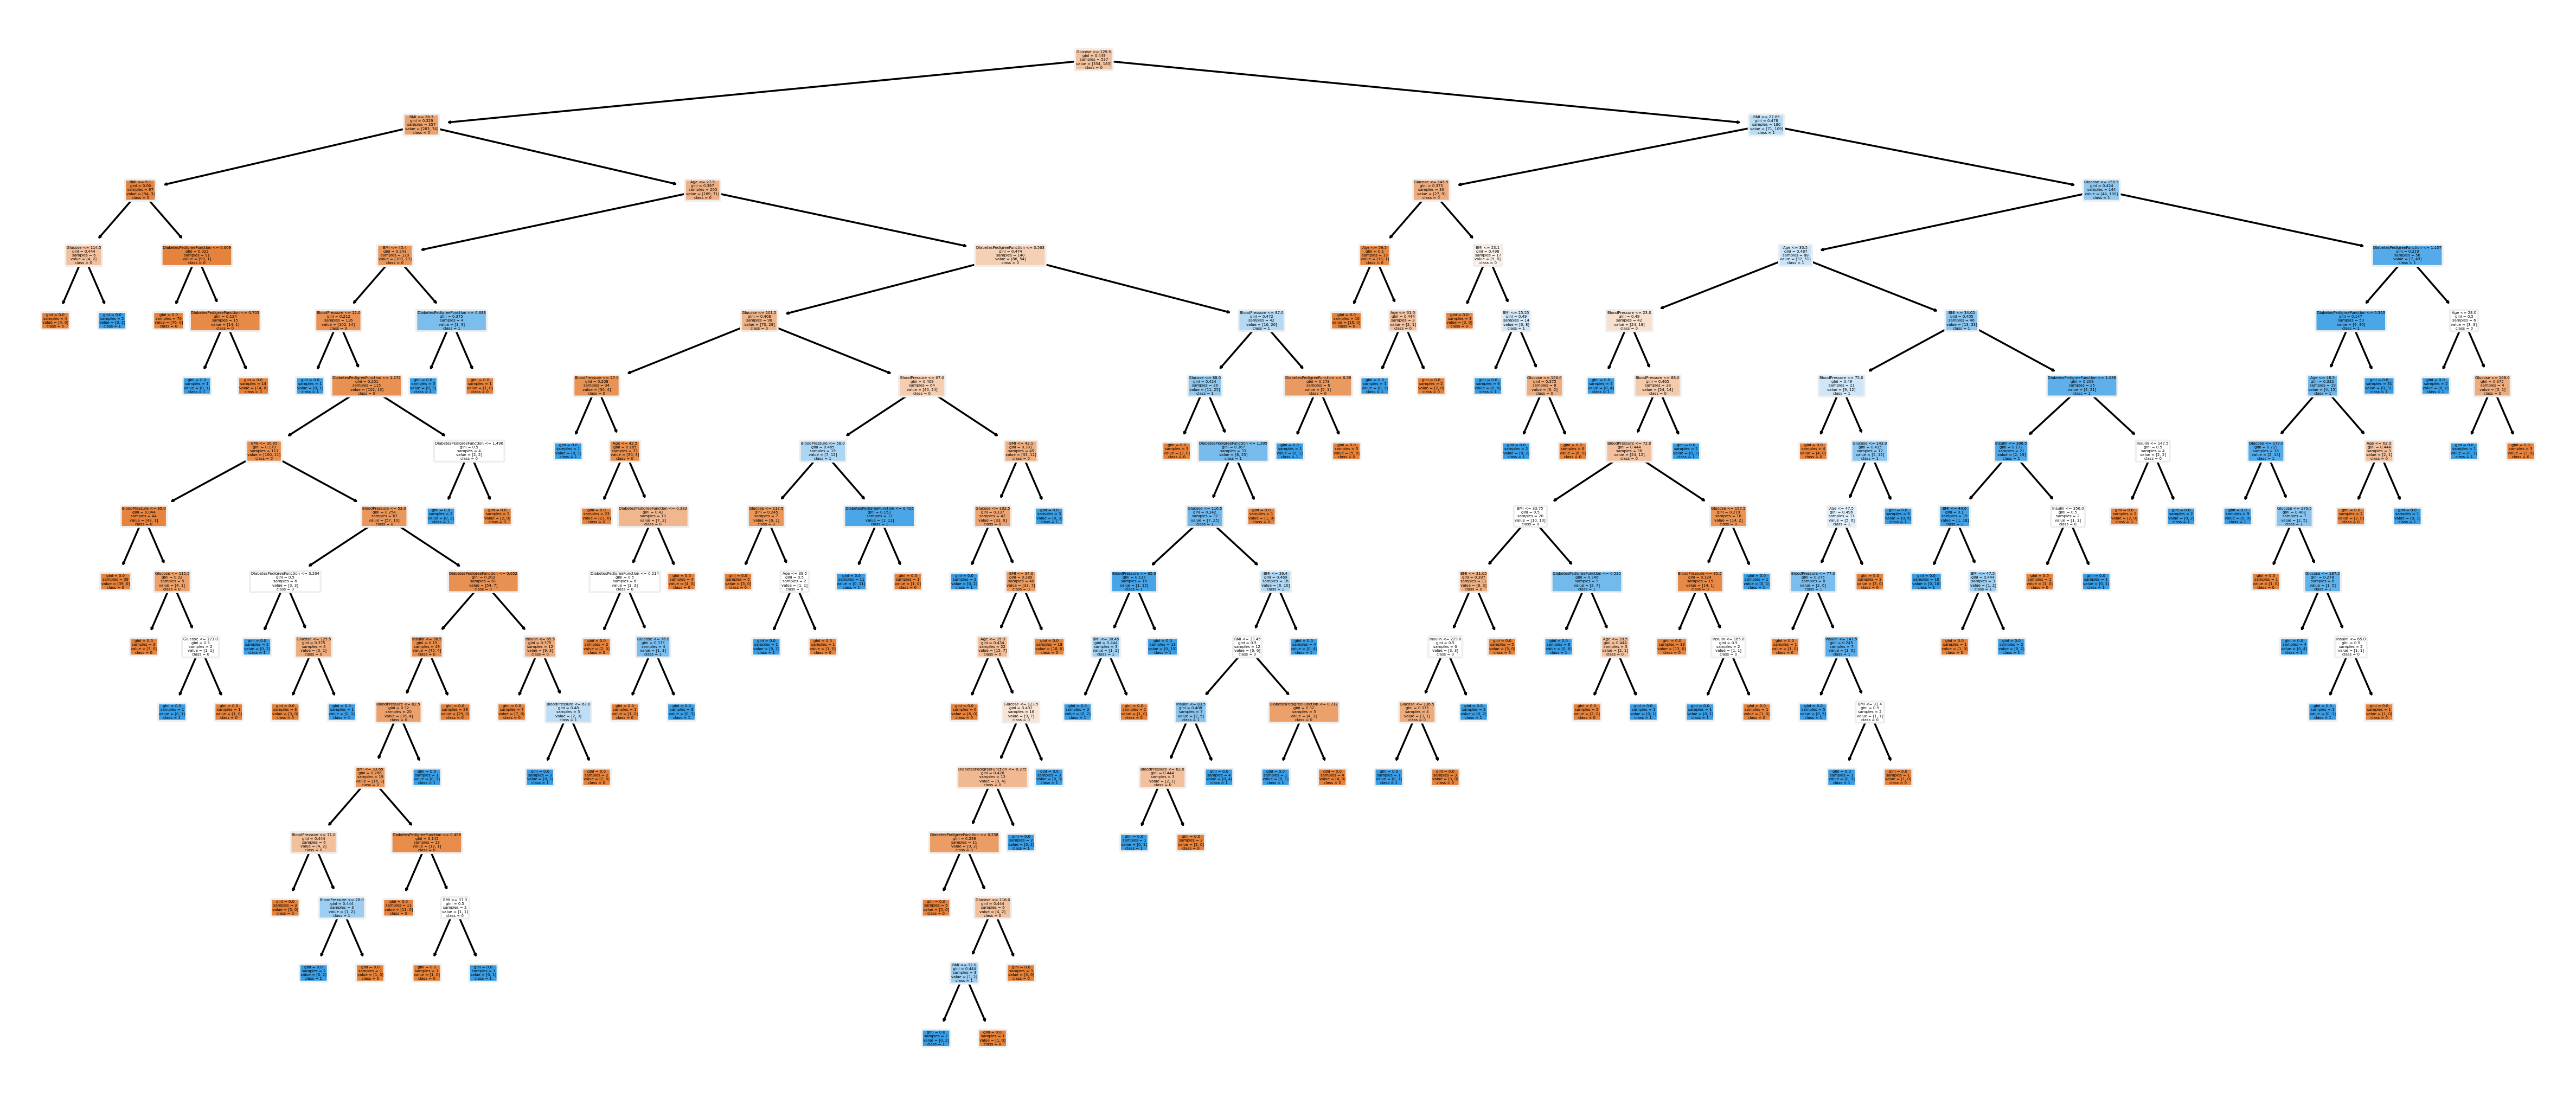

In [46]:
from sklearn import tree
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5), dpi=500)
tree.plot_tree(clf,
               feature_names=feature_cols,
               class_names=["0", "1"],
               filled=True,
               rounded=True);
plt.savefig('dtree.png')

In [47]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier(criterion="entropy", max_depth=3)

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7705627705627706


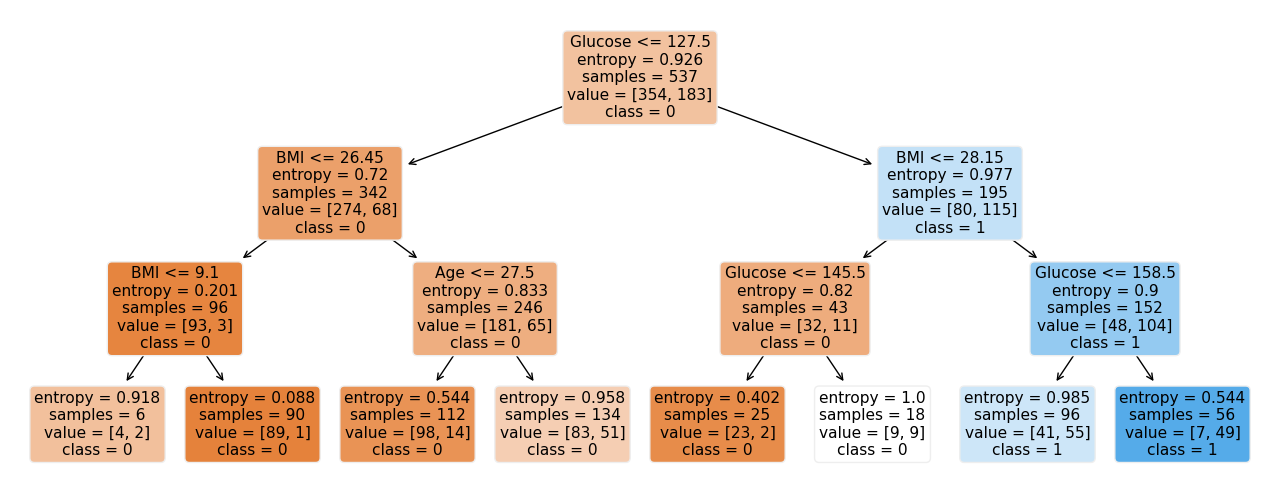

In [48]:
plt.figure(figsize=(8, 3), dpi=200)
tree.plot_tree(clf,
               feature_names=feature_cols,
               class_names=["0", "1"],
               filled=True,
               rounded=True);
plt.savefig('diabetes.png')

<Axes: >

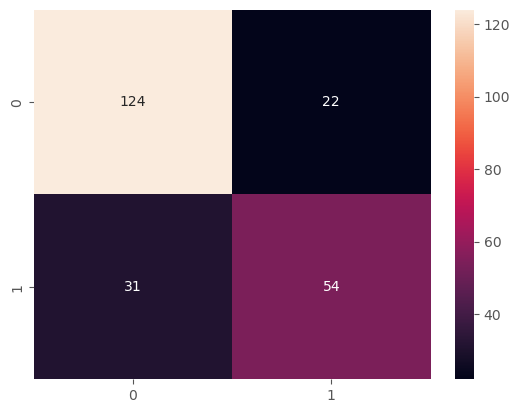

In [49]:
from sklearn.metrics import confusion_matrix
matrix= confusion_matrix(y_test, y_pred)
sns.heatmap(matrix,annot = True, fmt = "d")

In [50]:
from sklearn.metrics import precision_score
precision = precision_score(y_test, y_pred)
print("Precision: ",precision)

Precision:  0.7105263157894737


In [51]:
from sklearn.metrics import recall_score
recall = recall_score(y_test, y_pred)
print("Recall is: ",recall)

Recall is:  0.6352941176470588


In [52]:
#FSCORE
print((2*precision*recall)/(precision+recall))

0.6708074534161491
